In [2]:
import numpy as np
import scipy as sp
import scipy.optimize as sp_opt
import scipy.signal as sp_sig
import matplotlib.pyplot as plt

import Robustness.validation as valid
import gaussian_fitting as gaussfit
import bessel_fitting as bessfit
import misc_functions as misc

In [ ]:
# Define the number of data points.
n_datapoints=100

# Generate the noisy gaussian, use the default options execpt for the data points.
x_values,y_values = gaussfit.generate_noisy_gaussian(0,1,0,n_datapoints=n_datapoints)

# Generate a fit of the noisy gaussian data.
fit_parameters,covariance = gaussfit.fit_gaussian(x_values,y_values)

# Reassign the fit parameters, generate values to plot the gaussian function.
fit_mean,fit_std_dev,fit_height = fit_parameters
fit_x_values = np.linspace(-3,3,n_datapoints*10)
fit_y_values = gaussfit.gaussian_function(fit_x_values,fit_mean,fit_std_dev,fit_height)

# Plot the information of the generated gaussian data and the fit.
plt.plot(x_values,y_values,'.',label='Generated Data')
plt.plot(fit_x_values,fit_y_values,label='Gaussian Fit')
plt.legend()
plt.show()

# Print the values of the fitted parameters.
print('Central Mean:  ',fit_parameters[0])
print('Std dev:  ',fit_parameters[1])
print('Height:  ',fit_parameters[2])

In [ ]:
# Using Monte-Carlo methods for testing.
bin_size = 10000
bin_count = 1000

# Delta parameters
delta_mean = 1e-3
delta_std_dev = 1e-3
delta_height = 1e-3

# Inital conditions
test_mean = 1
test_std_dev = 1
test_height = 0

# Generate a large dataset of potenial points and their results+noise.
n_datapoints = 1000000
x_domain = [-3,3]
#noise_domain = [-1,1]
max_absolute_noise = 10
test_count = 1000

# Extra stuff to ensure there is no uneeded loop time
mean_break = False
std_dev_break = False
height_break = False

# Test the algorithim under increasing values of the noise domain.
for noisedex in np.linspace(0,max_absolute_noise,test_count):
    noise_domain = [-noisedex,noisedex]
    
    # Archive the information data to conduct stats.
    list_fit_mean = []
    list_fit_std_dev = []
    list_fit_height = []
    
    x_value_array,y_value_array = generate_noisy_gaussian(mean=test_mean,std_dev=test_std_dev,height=test_height,
                                                      x_domain=x_domain,noise_domain=noise_domain,
                                                      n_datapoints=n_datapoints)

    # From the dataset, generate the bins from random values, double sampling 
    # between bins is allowed.
    for bindex in range(bin_count):
        # Create a list of random indexes and extract a subset of the data.
        selected_indexes = np.random.randint(0,n_datapoints,size=bin_size)
        x_values_bin = np.array(x_value_array[selected_indexes])
        y_values_bin = np.array(y_value_array[selected_indexes])
        
        # Fit the values in each bin with a gaussian fit.
        fit_parameters,covariance = fit_gaussian(x_values_bin,y_values_bin)
        """
        # Generate an array for plotting values. Reusing the n_datapoints variable.
        plotting_x_values = np.linspace(x_domain[0],x_domain[-1],n_datapoints)
        plotting_y_values = gaussian_function(plotting_x_values,
                                          fit_parameters[0],fit_parameters[1],fit_parameters[2])
        
        # Print the information
        # Plot the information of the generated gaussian data and the fit.
        plt.plot(x_values_bin,y_values_bin,'.',label='Generated Data')
        plt.plot(plotting_x_values,plotting_y_values,label='Gaussian Fit')
        plt.legend()
        plt.show()
        
        # Print the values of the fitted parameters.
        print('Central Mean:  ',fit_parameters[0])
        print('Std dev:  ',fit_parameters[1])
        print('Height:  ',fit_parameters[2])
    
        # A dividing line for easier reading.
        print('==========================================')
        """
        
        # Save the fit parameters for the current run.
        list_fit_mean.append(fit_parameters[0])
        list_fit_std_dev.append(fit_parameters[1])
        list_fit_height.append(fit_parameters[2])
    
        # Remove unneeded values (just to make sure it is not repeated).
        del selected_indexes,fit_parameters
        #print(bindex)
    
    # Test the averages of the fitted values and see if the difference is too large.
    if (np.abs(np.average(list_fit_mean) - test_mean) > delta_mean):
        print('Mean failed at a noisedex of  ', noisedex)
        mean_break = True
    if (np.abs(np.average(list_fit_std_dev) - test_std_dev) > delta_std_dev):
        print('Std Dev failed at a noisedex of  ', noisedex)
        std_dev_break = True
    if (np.abs(np.average(list_fit_height) - test_height) > delta_height):
        print('Height failed at a noisedex of  ', noisedex)
        height_break = True
        
    # If all three values broke, end the loop.
    if (mean_break and std_dev_break and height_break):
        print('End!')
        break
    else:
        pass
        #print(noisedex)

In [ ]:
print(np.abs(np.average(list_fit_mean) - test_mean),
np.abs(np.average(list_fit_std_dev) - test_std_dev),
np.abs(np.average(list_fit_height) - test_height))

In [ ]:
center_list = [-1,-4,0,3,5]
std_dev_list = [1,1,1,1,1]
height_list = [-1,-0.5,0,0.5,1]
x_domain_list = np.array([[-10,10],[-10,10],[-10,10],[-10,10],[-10,10]])
noise_domain_list = x_domain_list / 10000
n_datapoints = 10000


In [ ]:
x_points,y_points = gaussfit.generate_noisy_multigaussian(center_list,std_dev_list,height_list,
                                                          noise_domain_list,x_domain_list,n_datapoints=n_datapoints)

In [ ]:
plt.plot(x_points,y_points)
plt.show()

In [ ]:
fourier = np.fft.fft(y_points)
#plt.plot(np.abs(fourier))
print(np.abs(fourier[1:-1000]))
fourier[100:] = 0
rev_fourier = np.fft.ifft(fourier)

plt.plot(np.abs(rev_fourier))
plt.show()

peak_index = np.array(sp_sig.find_peaks(np.abs(rev_fourier),prominence=0.1)[0],dtype=int)
print(x_points[peak_index])

In [ ]:
data = gaussfit.fit_multigaussian(x_points,y_points,fft_keep=0.001)
centers = data[0]
std_devs = data[1]
heights = data[2]
print(std_devs)

In [ ]:
plt.plot(x_points,gaussfit.gaussian_function(x_points,centers[0],std_devs[0],heights[0]))
plt.plot(x_points,gaussfit.gaussian_function(x_points,centers[1],std_devs[1],heights[1]))
plt.plot(x_points,gaussfit.gaussian_function(x_points,centers[2],std_devs[2],heights[2]))
plt.plot(x_points,gaussfit.gaussian_function(x_points,centers[3],std_devs[3],heights[3]))
plt.plot(x_points,y_points)
plt.show()

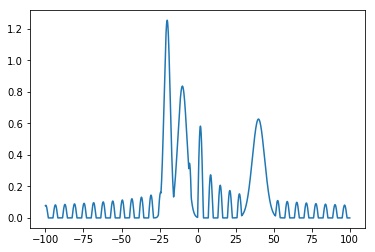

In [65]:
x_inputs = np.linspace(-100,100,10000)

functions = (gaussfit.gaussian_function,
             gaussfit.gaussian_function,
             gaussfit.gaussian_function,
             bessfit.bessel_function_1st
            )
parameters = (
    {'center':-10, 'std_dev':3, 'height':0},
    {'center':-20, 'std_dev':2, 'height':0},
    {'center':40, 'std_dev':4, 'height':0},
    {'order':1}
)


y_output = misc.generate_function_envelope(x_inputs,functions,parameters)

plt.plot(x_inputs,y_output)
plt.show()

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


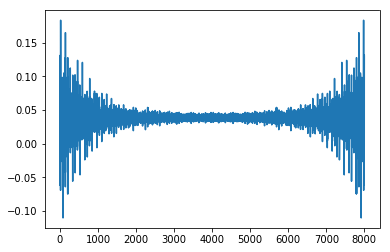

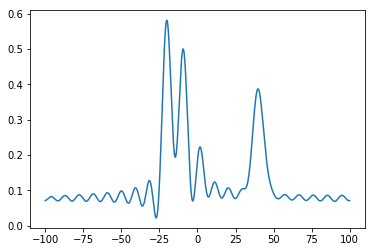

[-20.1520152   -9.41094109  39.7939794 ]


In [70]:
y_fft = np.fft.fft(y_output)
plt.plot(y_fft[view:-view])
plt.show()

y_fft[22:] = 0
y_ifft = np.fft.ifft(y_fft)
plt.plot(x_inputs,y_ifft)
plt.show()

find_index = sp_sig.find_peaks(y_ifft,prominence=0.25)[0]
print(x_inputs[find_index])

[-95.23952395 -81.51815182 -67.75677568 -54.03540354 -40.3740374
 -26.85268527 -10.3510351    3.95039504  20.2120212   38.79387939
  63.25632563  77.23772377  91.13911391]


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
